CHEN 6603....Homework Set #12
  .........................this script was created by PJS - fall 2019  
  
 This script will compute the production rate of ethylene oxide ($\text{C}_2\text{H}_4\text{O}$) from the direct oxidation of ethylene ($\text{C}_2\text{H}_4$) with competing oxidation reactions over a silver catalyst (Theodore Lefort) in a plug flow reactor. This uses thin film approximation (method 2).

Note: The key concepts needed to get the right answer and full credit, is the proper bootstrap (fixed flux ratios according to the given stoichiometry for all reactants and products, and zero flux for the inert) and recognizing that the concentration at the catalyst surface is unknown. It is obtained by determining that the molar flux from mass transfer and reaction are equal. The concentration of the one reamaining component comes from the sum of the mole fractions being one. 

Begin by importing some functions:

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from scipy.optimize import fsolve
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')    # if on a MacBook Pro
import matplotlib.pyplot as plt
from ipynb.fs.defs.GMS import GMSres

1$^{\text{st}}$  define the system inputs: 

In [2]:
ns         = 6                      # number of species
lreactor   = 12.8                    # reactor length, m
nl         = 200                    # number of reactor cells
dl         = lreactor / nl          # distance (m) for each spatial step
spec_names = ['N$_2$', 'O$_2$', 'C$_2$H$_4$', 'C$_2$H$_4$O', 'CO$_2$', 'H$_2$O']
M          = np.array([28, 32, 28, 44, 44, 18])               # vector of mole wts
V          = np.array([18.5, 16.3, 41, 46.5, 26.9, 13.1])     # vector of diffusion volumes
xin        = [1274/1446, 91.5/1446, 80.5/1446, 0, 0, 0]       # reactor inlet mol frac
L          = 5e-3                   # characteristic length for correlation, m
T          = 228 + 273.15           # temperature, K
P          = 2 * 101325             # pressure, Pa
ν          = 4e-5                   # kinematic viscosity, m^2/s
R          = 8.3144598              # ideal gas constant, m^3,Pa,K,mol
α          = 1.013e-2               # constant for Fuller equation
C          = 0.683                  # constant for equation 2
m          = 0.466                  # constant for equation 2
f23        = 4/3                    # flux ratio O2/C2H4
f43        = -2/3                   # flux ratio C2H4O/C2H4
f53        = -2/3                   # flux ratio CO2/C2H4
f63        = -2/3                   # flux ratio H2O/C2H4
c          = P / (R * T)            # total concentration of mixture, mol/m^3
v          = 1446 * 1000 / 3600 / c / (np.pi * (.03912/2)**2 * 2781)           # superficial velocity, m/s
Re         = v * L / ν              # Reynolds Number
a          = 4396/(lreactor * np.pi * (.03912/2)**2 * 2781)                    # surface area to volume ratio of catalyst, 1/m
print('Superficial velocity, m/s:', v)
print('Table entries for correlation:', Re, C, m)
print('SA/V of catalyst, 1/m:', a)

Superficial velocity, m/s: 2.47077042496349
Table entries for correlation: 308.84630312043623 0.683 0.466
SA/V of catalyst, 1/m: 102.7446345237056


Now define the needed arrays and inlet conditions

In [3]:
Đ  = np.empty((ns, ns))
kc = np.empty((ns, ns))
Sc = np.empty((ns, ns))
Sh = np.empty((ns, ns))
x0 = np.empty((ns))
xδ = np.empty((ns))
xf = np.empty((ns))
J  = np.zeros((ns))
N  = np.zeros((ns))

unknowns       = np.empty(ns+ns-1)
answers        = np.empty(ns+1)
distance       = np.linspace(0, lreactor, nl+1)
xreactor       = np.zeros((ns, nl+1))  # reactor concentrations (mol frac)
x0reactor      = np.zeros((ns, nl+1))  # catalyst surface concentration (mol frac)
flxreactor     = np.zeros((ns, nl+1))  # flux of each component down the reactor
tflxreactor    = np.zeros(nl+1)        # total flux down length of reactor
effectiveness  = np.empty(nl+1)        # effectiveness factor down the reactor
selectivity    = np.empty(nl+1)        # selectivity down the reactor
yldreactor     = np.empty(nl+1)        # reactor yield
Jreactor       = np.zeros((ns, nl+1))  # diffusive flux from surface
Nreactor       = np.zeros((ns, nl+1))  # total flux from surface
xreactor[:, 0] = xin
flxreactor     = xreactor[:, :] * v * c
tflxreactor[0] = np.sum(flxreactor[0:ns-1, 0])
x0[:]          = xin                        # initial guess...solved below
N[:]           = [0, -.3, -.4, .2, .2, .2]  # initial guess...solved below
print(' initial reactor flux is ', tflxreactor[0], ' mol/m^2/s: ')

 initial reactor flux is  120.16478942171939  mol/m^2/s: 


Next define the Nonlinear function for the residuals

In [4]:
def Res(unknowns, xδ, c, a, kc):
    global J, effect, select
    # first defined needed variables
    resid = np.empty(ns+ns-1)
    N     = unknowns[:ns]
    N[0]  = 0                           # the inert flux is known
    x0    = [1-sum(unknowns[ns:]), unknowns[ns], unknowns[ns+1], unknowns[ns+2], unknowns[ns+3], unknowns[ns+4]]   # this and the J definitions below define the bootstrap
    x     = (x0[:] + xδ[:]) / 2         # get average composition for the flux
    d     = (xδ[:] - x0[:])             # obtain ns driving forces
    J     = N  - x * sum(N[:])
    # the reaction
    k1   = 8.63e7 * 1e6
    k2   = 6.57e7 * 1e6
    c1_0 = x0[2] * c / 1e6
    c2_0 = x0[1] * c / 1e6
    F1_0 = (0.0106 + 2144 * c1_0 + 805 * c2_0) * (1 + 1271 * np.sqrt(c2_0))
    F2_0 = (0.008 + 4166 * c1_0 + 1578 * c2_0) * (1 + 718 * np.sqrt(c2_0))
    r1_0 =  k1 / a * c1_0 * c2_0**2 / F1_0**2
    r2_0 =  k2 / a * c1_0 * c2_0**2 / F2_0**2
    c1_δ = xδ[2] * c / 1e6
    c2_δ = xδ[1] * c / 1e6
    F1_δ = (0.0106 + 2144 * c1_δ + 805 * c2_δ) * (1 + 1271 * np.sqrt(c2_δ))
    F2_δ = (0.008 + 4166 * c1_δ + 1578 * c2_δ) * (1 + 718 * np.sqrt(c2_δ))
    r1_δ = k1 / a * c1_δ * c2_δ**2 / F1_δ**2
    r2_δ = k2 / a * c1_δ * c2_δ**2 / F2_δ**2    
    effect = (r1_0 + r2_0) / (r1_δ + r2_δ)
    select = r1_0 / (r1_0 + r2_0)

    # and here are the constraints in residual form starting with the GMS equations
    
    resid[:ns]  = d - np.sum((np.outer(x, J) - np.outer(J, x)) / (c * kc), axis=1)
    resid[ns]   = N[1] + (0.5 * r1_0 + 3 * r2_0)          # mass fluxes have to match reaction rates
    resid[ns+1] = N[2] + (r1_0 + r2_0)
    resid[ns+2] = N[3] - r1_0
    resid[ns+3] = N[4] - 2 * r2_0
    resid[ns+4] = N[5] - 2 * r2_0

    return resid

Obtaining the Maxwell-Stefan Diffusivity matrix (Đ) from the Fuller Correlation & use heat transfer correlation for kc:

In [5]:
for i in range(ns):
    for j in range(ns):
        if i == j:
            Đ[i, j]  = 1
            kc[i, j] = 1
        else:
            Đ[i, j]  = (α * T**1.75 * np.sqrt((M[i] + M[j]) / (M[i] * M[j]))
                        / (P * (V[i]**(1/3) + V[j]**(1/3))**2) )
            Sc[i, j] = ν / Đ[i, j]
            Sh[i, j] = C * Re**m * Sc[i, j]**0.333
            kc[i, j]  = Đ[i, j] * Sh[i, j] / L
print(' kc = ', kc)

 kc =  [[1.         0.05865527 0.04826548 0.04372094 0.05002881 0.06814459]
 [0.05865527 1.         0.04839221 0.04359292 0.05000869 0.06901865]
 [0.04826548 0.04839221 1.         0.03719887 0.04188688 0.05586451]
 [0.04372094 0.04359292 0.03719887 1.         0.03737184 0.0513267 ]
 [0.05002881 0.05000869 0.04188688 0.03737184 1.         0.05913645]
 [0.06814459 0.06901865 0.05586451 0.0513267  0.05913645 1.        ]]


Solve the mass (molar) balance down the length of the reactor

In [6]:
for l in range(1, nl+1):
    xδ[:]          = xreactor[:, l-1]        # prescribed boundary condition
    unknowns[:ns]  = N[:]
    unknowns[ns:]  = [x0[1], x0[2],x0[3],x0[4],x0[5]]

    # This is where I solve for the fluxes from method 2 with x0[0]=0
    
    answers = fsolve(Res, unknowns, args=(xδ[:], c, a, kc))
    N       = answers[:ns]
    x0      = [1-sum(answers[ns:]), answers[ns], answers[ns+1], answers[ns+2], answers[ns+3], answers[ns+4]]
    
#     print(Res(answers, xδ, c, a, kc))
#     print(N)
#     print(f23, N[1]/N[2], f43, N[3]/N[2], f53, N[4]/N[2], f63, N[5]/N[2],)
#     print(x0)
#     stop

    # compute reactor flows for this cell
    
    flxreactor[:, l]  = flxreactor[:, l-1] + dl * a * N[:]
    tflxreactor[l]    = np.sum(flxreactor[:, l])
    xreactor[:,l]     = flxreactor[:, l] / tflxreactor[l]
    yldreactor[l-1]   = flxreactor[3, l] / flxreactor[2, 0]
    effectiveness[l-1]= effect
    selectivity[l-1]  = select
    x0reactor[:, l-1] = x0[:]
    Jreactor[:, l-1]  = J[:]
    Nreactor[:, l-1]  = N[:]
    
    # update heat transfer correlation with new velocity for next cell
    
    u    = tflxreactor[l] / c
    Re   = u * L / ν
    for i in range(ns):
        for j in range(ns):
            if i != j:
                Sh[i, j] = C * Re**m * Sc[i, j]**0.333
                kc[i, j]  = Đ[i, j] * Sh[i, j] / L
x0reactor[:, -1]  = x0reactor[:, -2]
effectiveness[-1] = effectiveness[-2]
selectivity[-1]   = selectivity[-2]
yldreactor[-1]    = yldreactor[-2]

Plot the requested results (mole fraction profile):

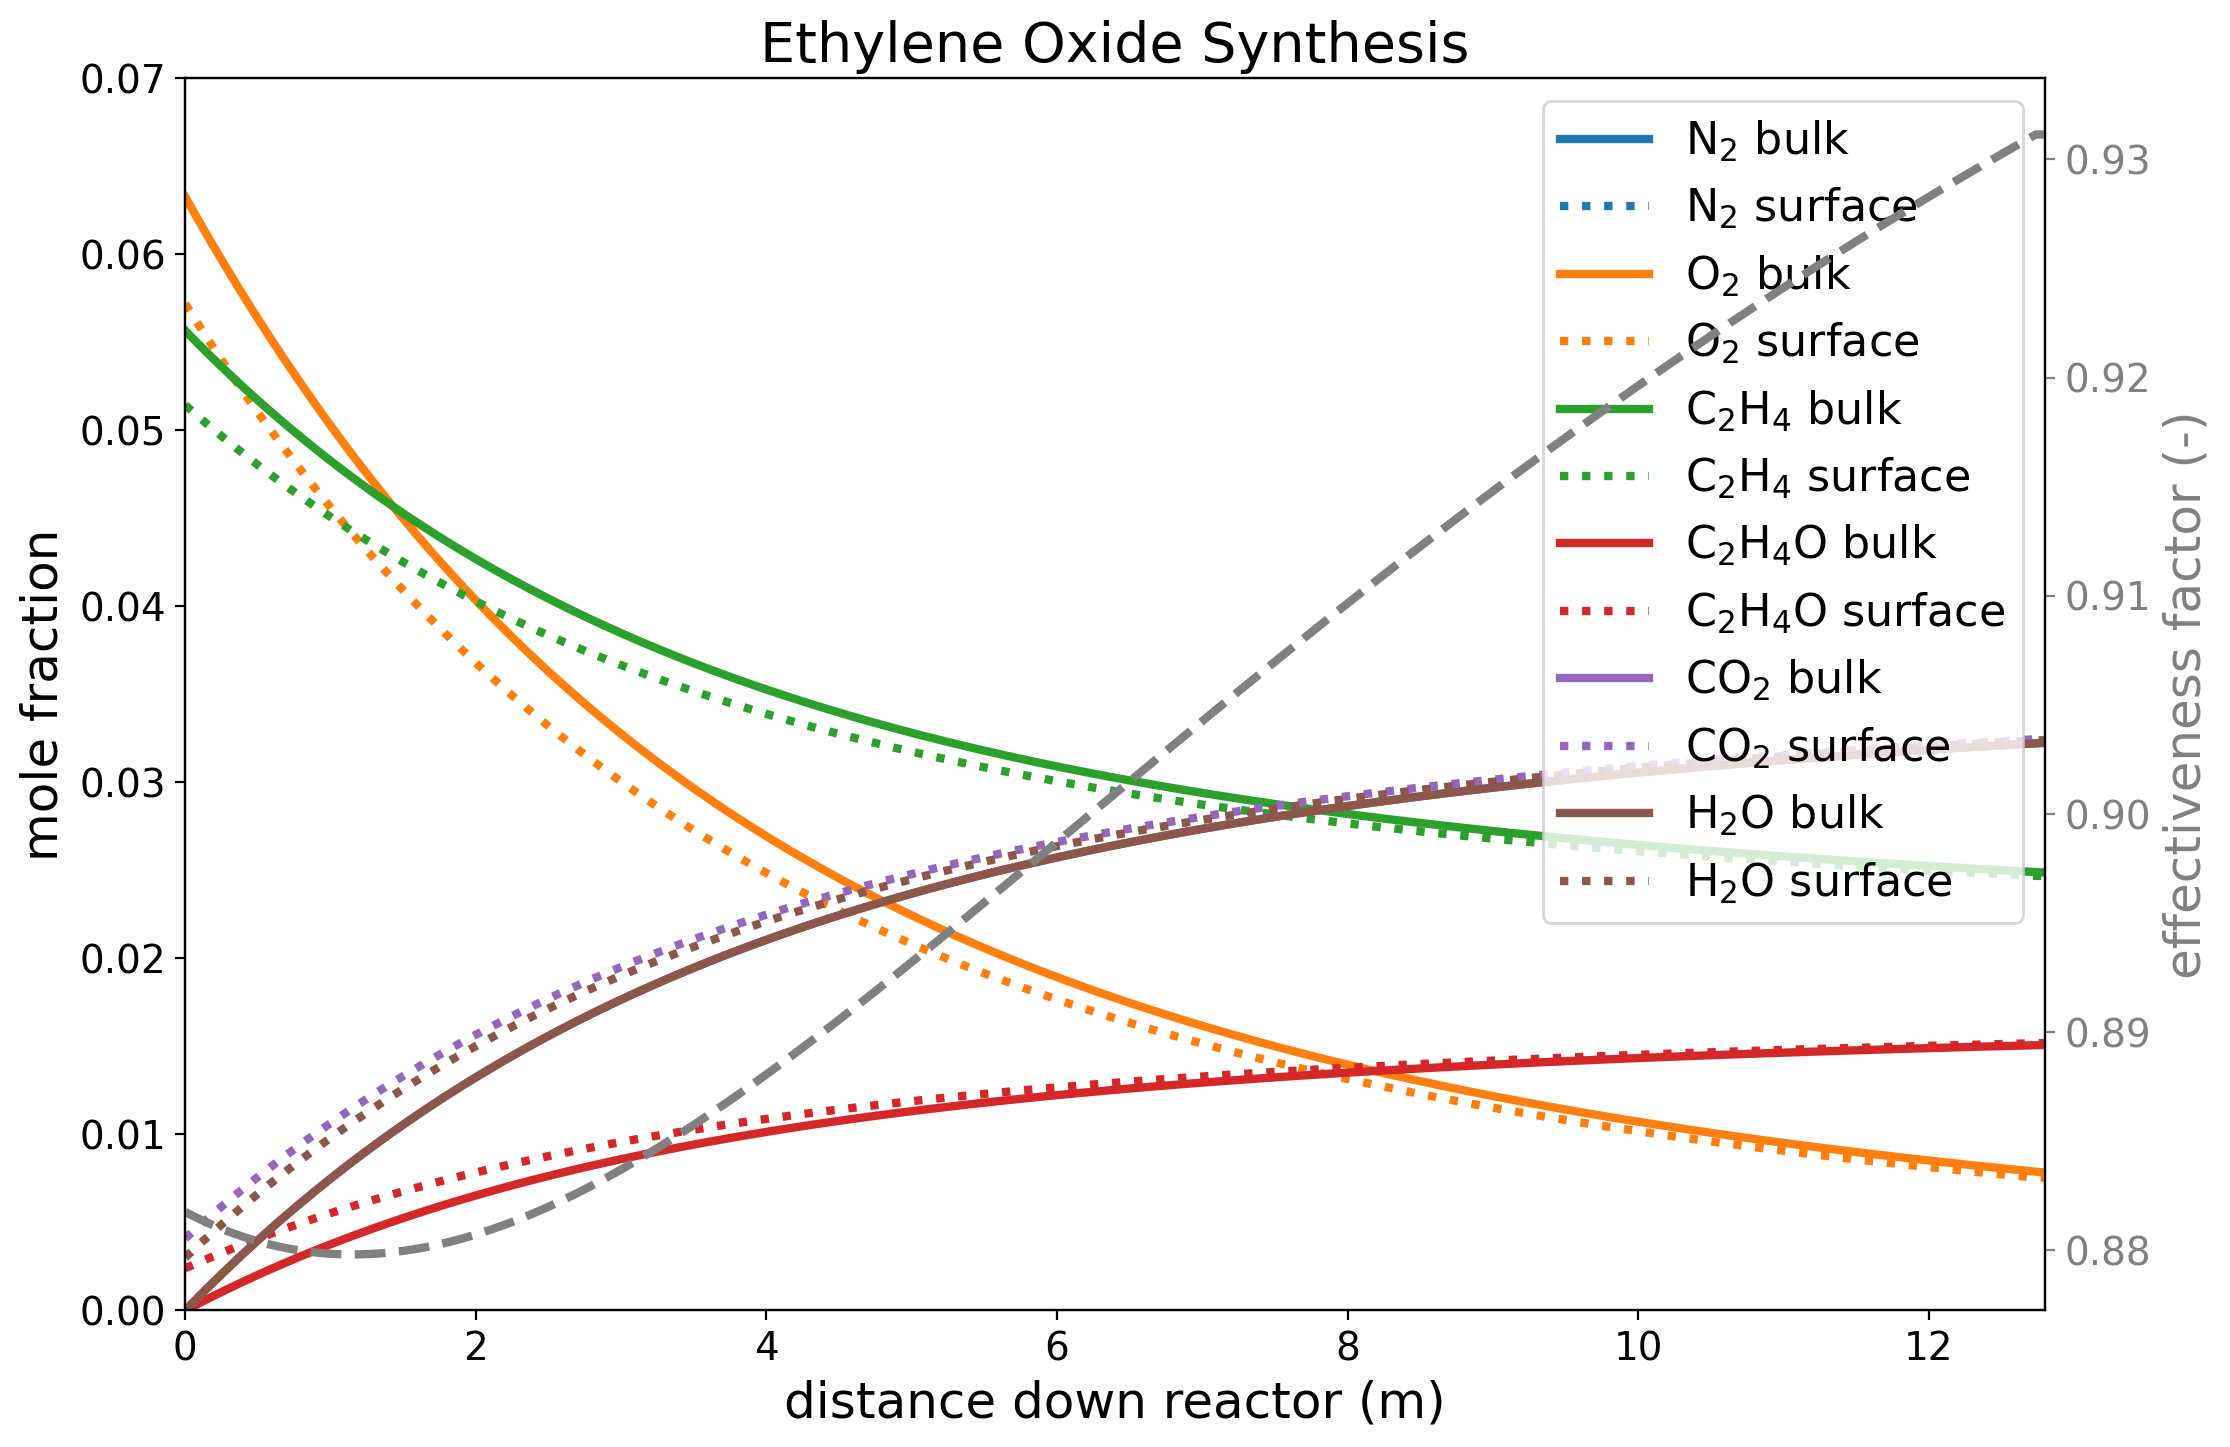

In [7]:
fig = plt.figure(figsize=(12,8))
for i in range(ns):
    p = plt.plot(distance, xreactor[i], linewidth=3, label='{} bulk'.format(spec_names[i]))
    plt.plot(distance, x0reactor[i], linewidth=3, linestyle=':', color=p[0].get_color(), label='{} surface'.format(spec_names[i]))
plt.xlim([0, lreactor])
plt.ylim([0, .07])
plt.xlabel('distance down reactor (m)', fontsize=18)
plt.ylabel('mole fraction', fontsize=18)
plt.title('Ethylene Oxide Synthesis', fontsize=20)
plt.legend(fontsize=16, loc='upper right')
# plt.legend(fontsize=16, bbox_to_anchor=(1.1, 1.0))
plt.gca().tick_params(axis='both', which='major', labelsize=14)
plt.gca().twinx()
plt.plot(distance, effectiveness, linewidth=3, linestyle='--', color='grey')
plt.gca().tick_params(axis='y', which='major', labelsize=14, color='grey', labelcolor='grey')
plt.ylabel('effectiveness factor (-)', color='grey', fontsize=18)
_ = plt.savefig('Hwk12x.pdf', transparent=True)

Plot some of the fluxes to understand the behavior:

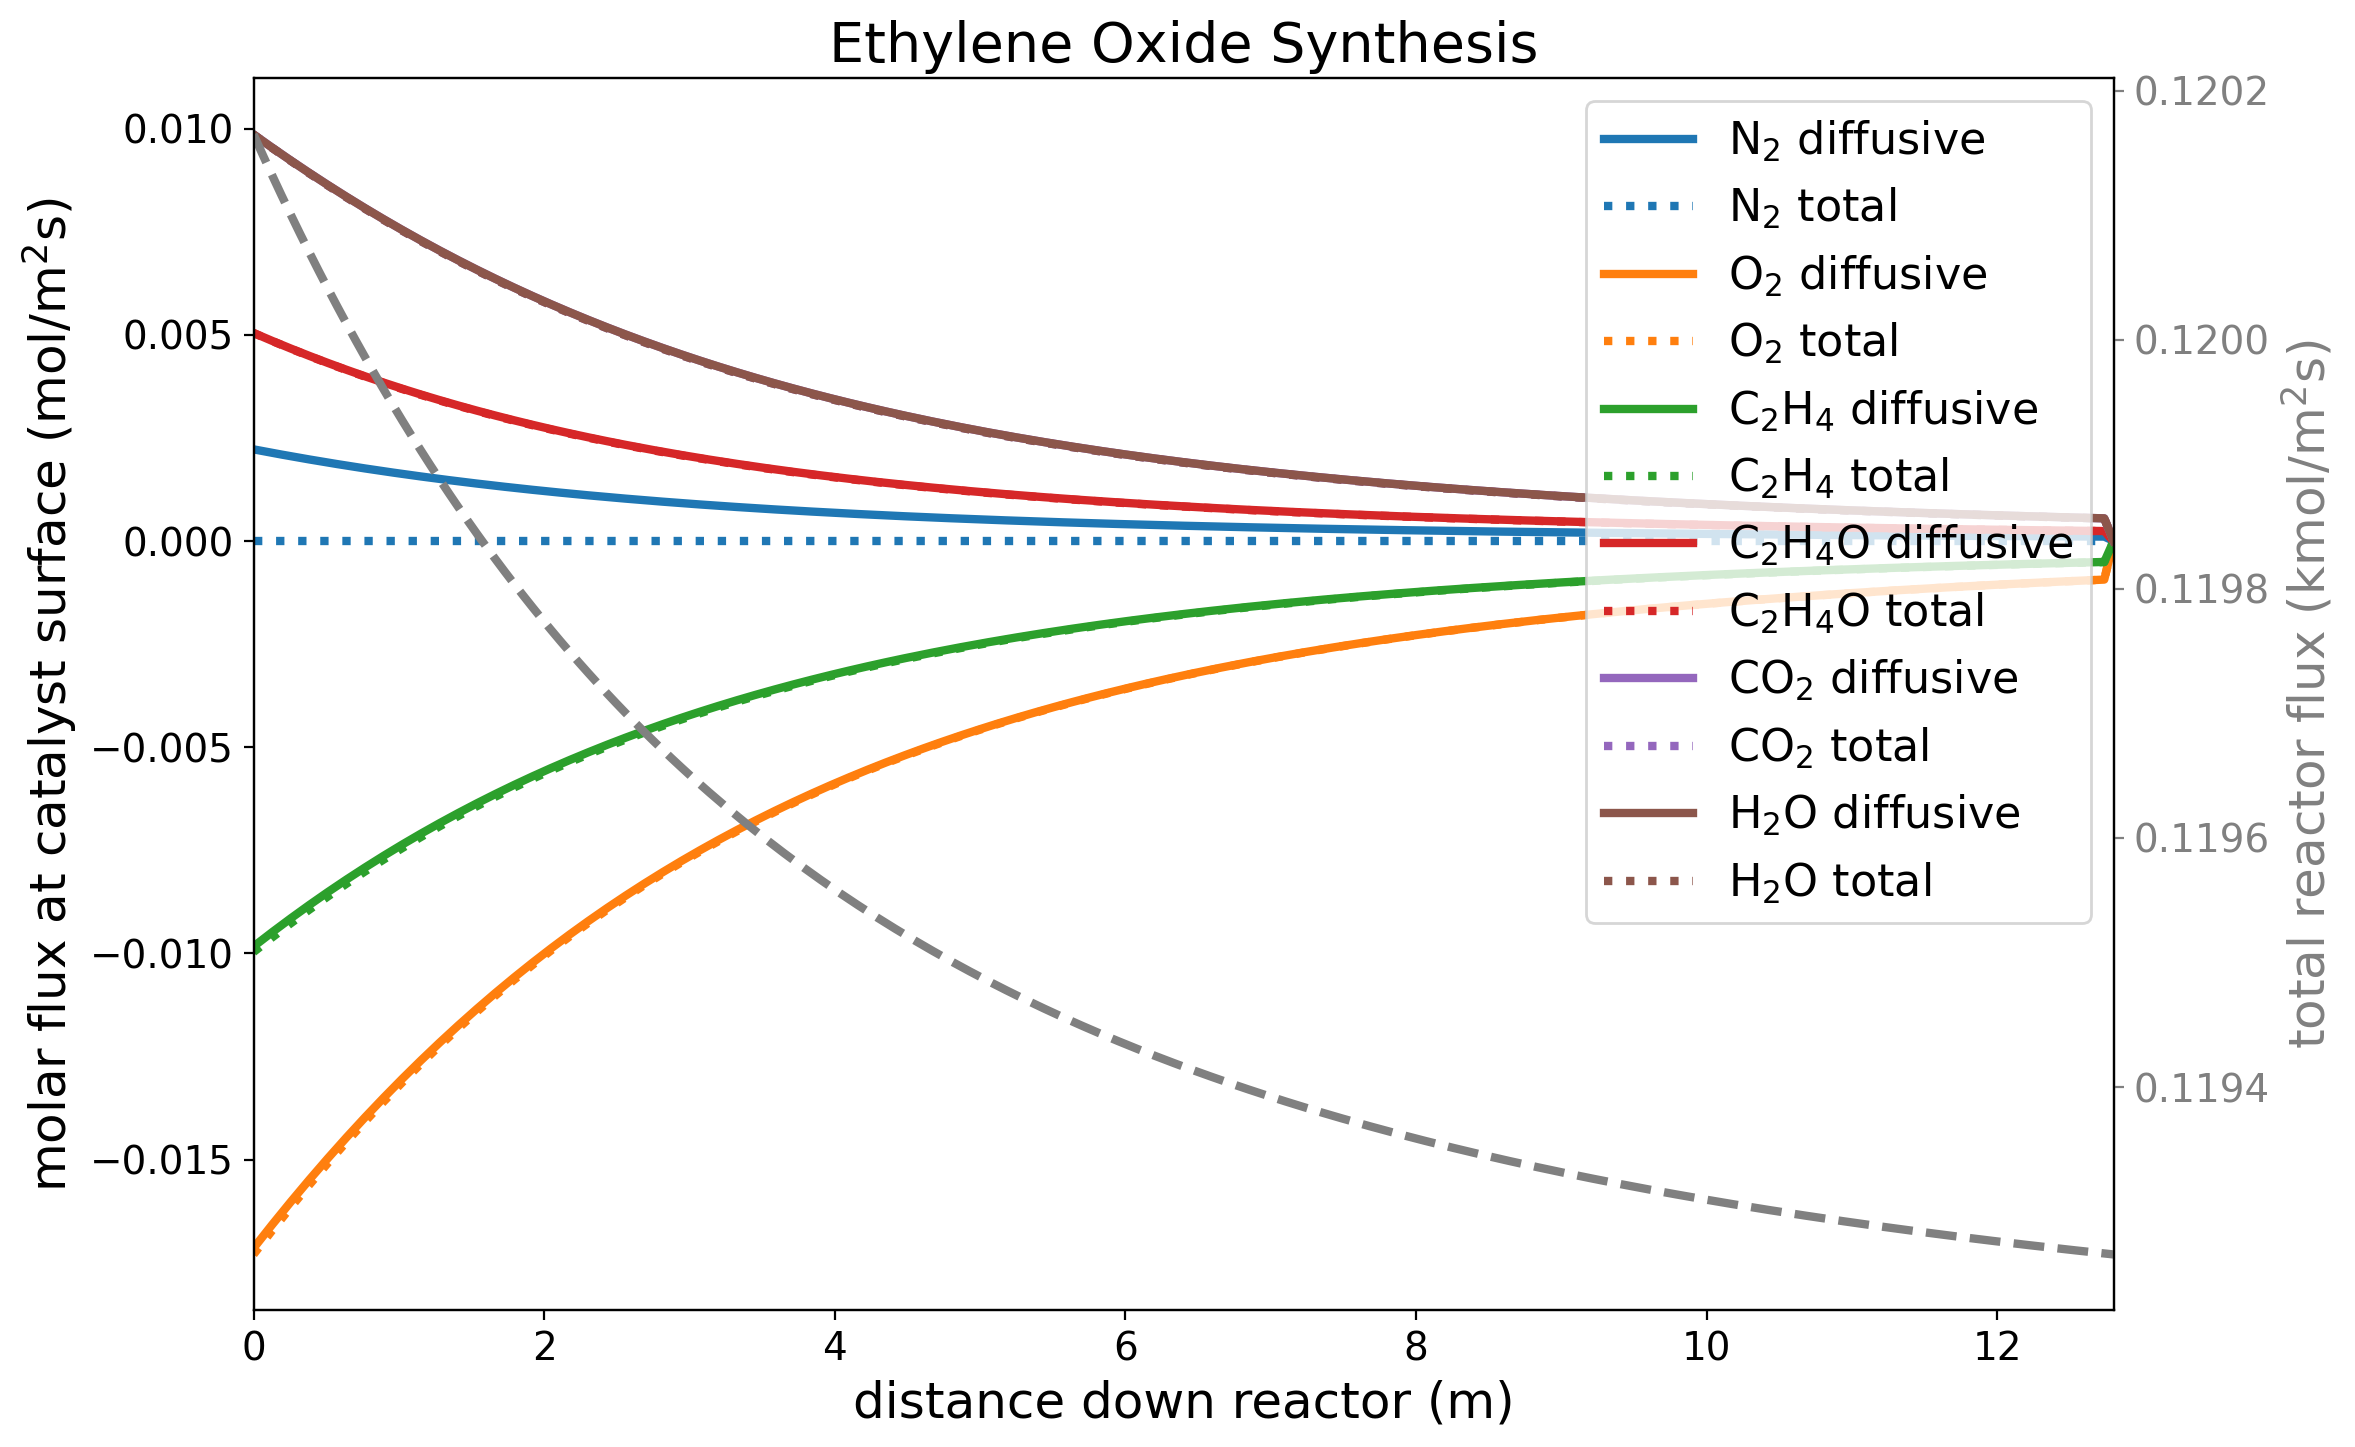

In [8]:
fig = plt.figure(figsize=(12,8))
for i in range(ns):
    p = plt.plot(distance, Jreactor[i], linewidth=3, label='{} diffusive'.format(spec_names[i]))
    plt.plot(distance, Nreactor[i], linewidth=3, linestyle=':', color=p[0].get_color(), label='{} total'.format(spec_names[i]))
plt.xlim([0, lreactor])
plt.xlabel('distance down reactor (m)', fontsize=18)
plt.ylabel('molar flux at catalyst surface (mol/m$^2$s)', fontsize=18)
plt.title('Ethylene Oxide Synthesis', fontsize=20)
#plt.legend(fontsize=16, bbox_to_anchor=(1, 0.65*1.0))
plt.legend(fontsize=16, loc='upper right')
plt.gca().tick_params(axis='both', which='major', labelsize=14)
plt.gca().twinx()
plt.plot(distance, tflxreactor/1000, linewidth=3, linestyle='--', color='grey')
plt.gca().tick_params(axis='y', which='major', labelsize=14, color='grey', labelcolor='grey')
plt.ylabel('total reactor flux (kmol/m$^2$s)', color='grey', fontsize=18)
_ = plt.savefig('Hwk12flx.pdf', transparent=True)

Plot the selectivity and yield curves:

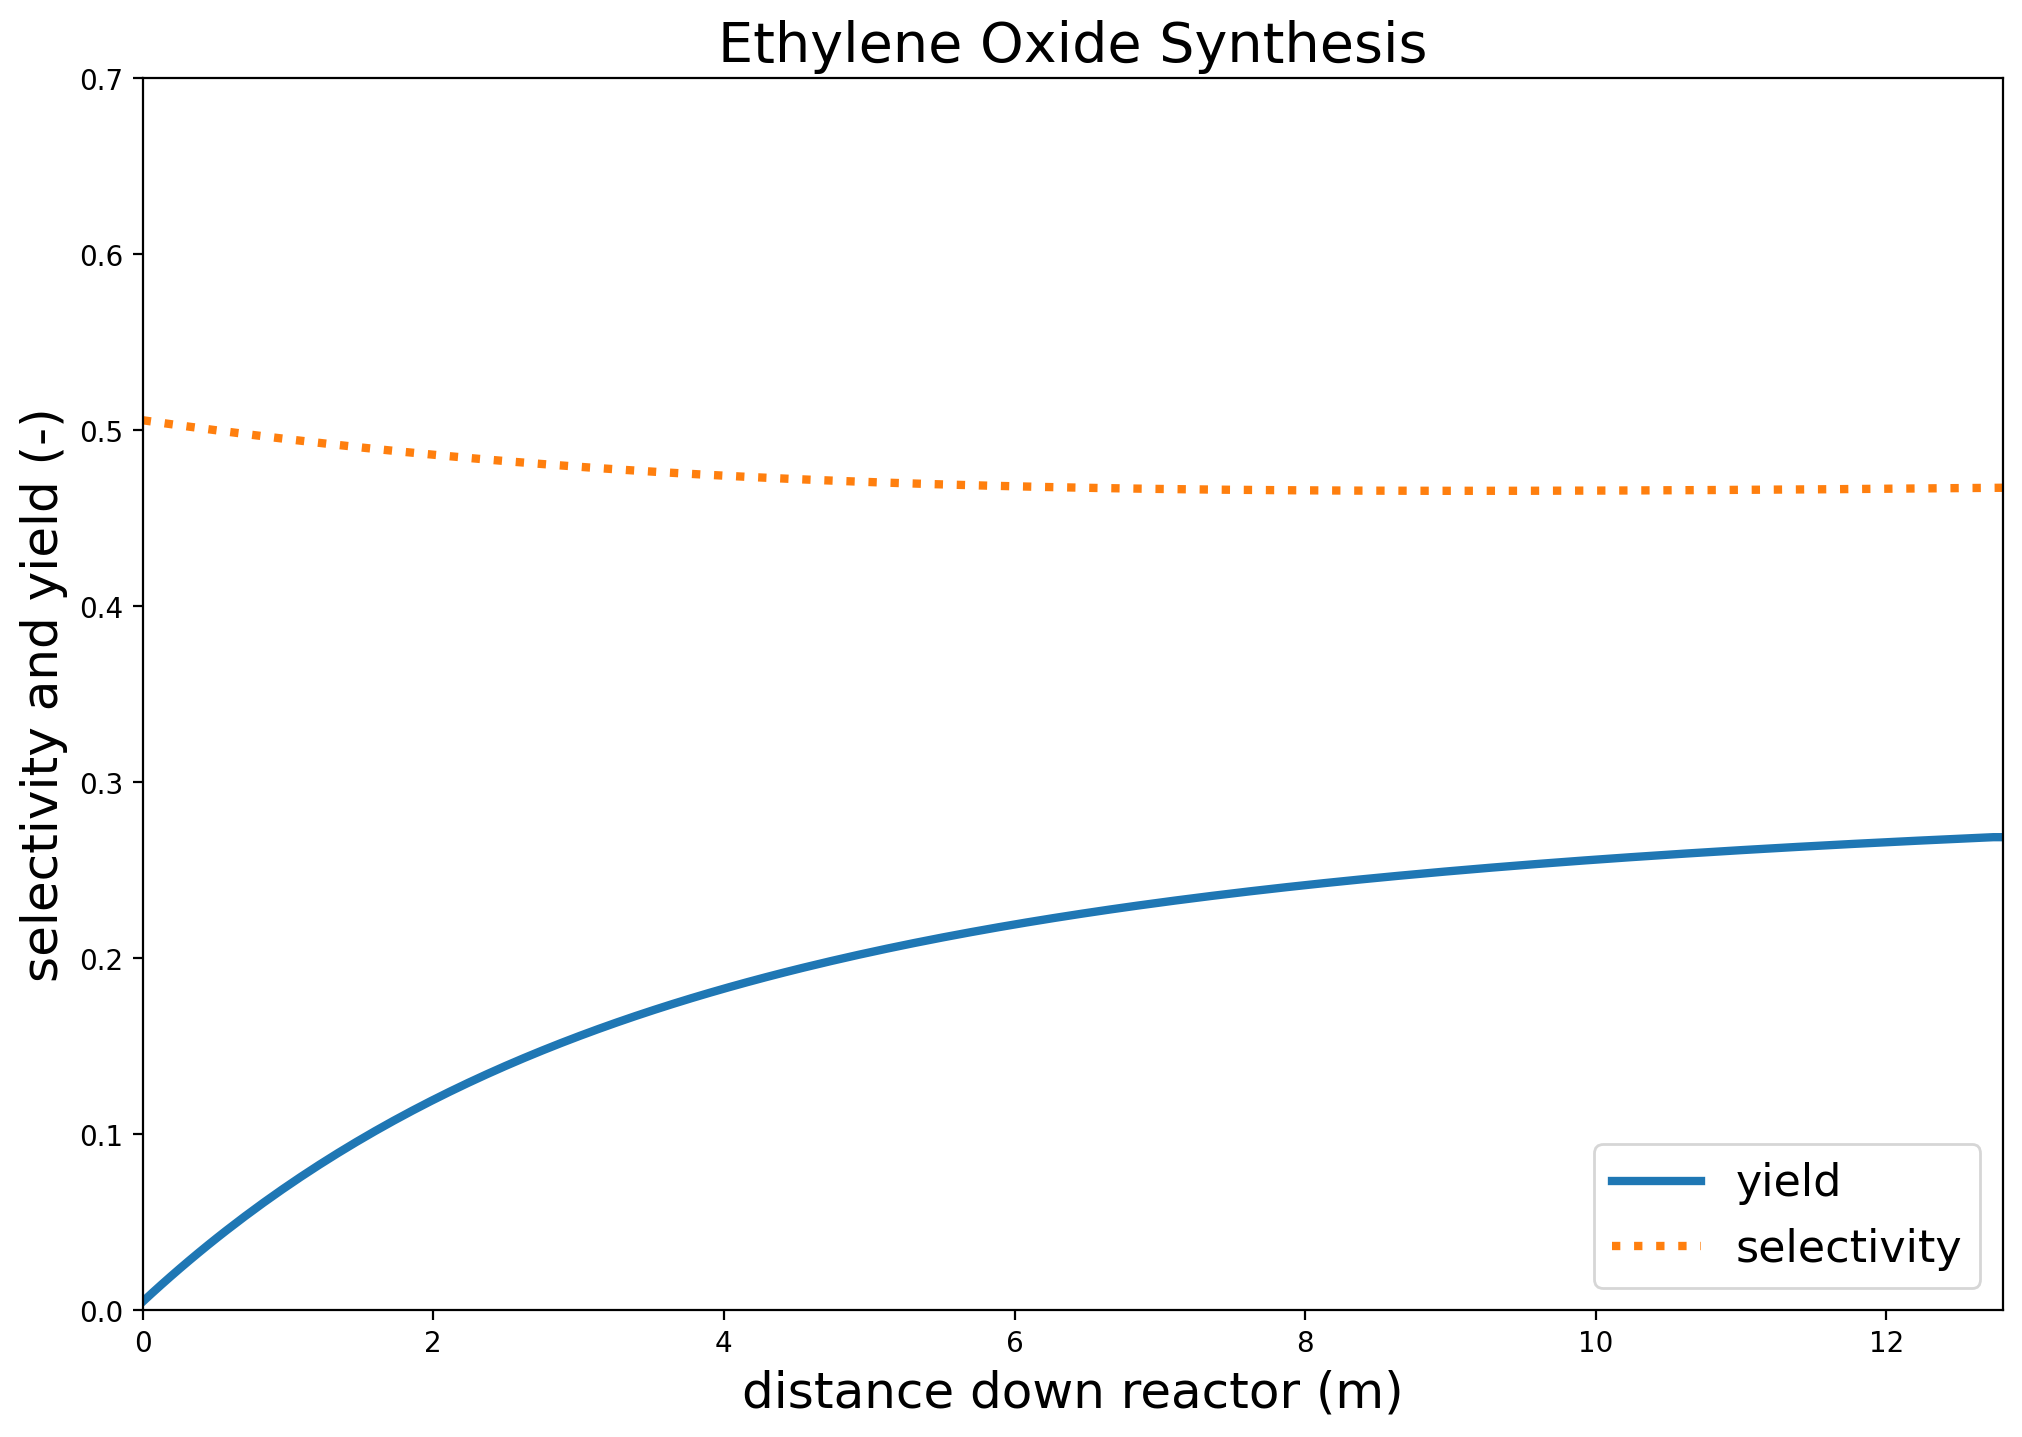

In [9]:
fig = plt.figure(figsize=(12,8))
p = plt.plot(distance, yldreactor, linewidth=3, label='yield')
plt.plot(distance, selectivity, linewidth=3, linestyle=':', label='selectivity')
plt.ylim([0, .7])
plt.xlim([0, lreactor])
plt.xlabel('distance down reactor (m)', fontsize=18)
plt.ylabel('selectivity and yield (-)', fontsize=18)
plt.title('Ethylene Oxide Synthesis', fontsize=20)
plt.legend(fontsize=16, loc='lower right')
_ = plt.savefig('Hwk12sy.pdf', transparent=True)

QED  